In [1]:
import soundfile as sf
import numpy as np
from scipy import signal
import librosa.feature as feat
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Conv2D
from sklearn.preprocessing import StandardScaler

# Import et création du data frame (à ne pas lancer)

Les extraits ne peuvent pas être urilisés comme tel. Nous allons donc extraire des données utiles et les stocker dans un DataFrame. Celui-ci sera ensuite sauvegardé au format pickle pour éviter de relancer l'extraction à chaque fois

In [2]:
#Fonction pour importer un audio et en extraire les features utiles

def import_son(nom):
    import soundfile as sf
    filename = nom 
    sig, sr = sf.read(r'.\data\X_train\\' + filename)

    sos = signal.butter(6, [5000, 100000], 'bandpass', fs=sr, output='sos')
    sig = signal.sosfiltfilt(sos, sig)
    rms = feat.rms(y=sig) 
    sc = feat.spectral_centroid(y=sig, sr=sr)
    sb = feat.spectral_bandwidth(y=sig,sr=sr)
    sf = feat.spectral_flatness(y=sig)

    features = [np.mean(rms), np.std(rms), np.min(rms), np.max(rms),\
                np.mean(sc), np.std(sc), np.min(sc), np.max(sc),\
                np.mean(sb), np.std(sb), np.min(sb), np.max(sb),\
                np.mean(sf), np.std(sf), np.min(sf), np.max(sf)]
    return([nom] + features)

In [3]:
#On récupère le nom des fichiers X_train

import os

def get_files(path):
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            yield file

list_files = []
for file in get_files(r'.\data\X_train'):
    if('wav' in file):
        list_files = list_files + [file]

In [4]:
list_files[0:5]

['00000-JAM.wav',
 '00001-JAM.wav',
 '00002-JAM.wav',
 '00003-JAM.wav',
 '00004-JAM.wav']

In [19]:
#Création du dataframe des caractéristiques de chaque son

df = pd.DataFrame(columns = ['nom','mean_rms', 'std_rms', 'min_rms', 'max_rms',
                'mean_sc', 'std_sc', 'min_sc', 'max_sc',
                'mean_sb', 'std_sb', 'min_sb', 'max_sb',
                'mean_sf', 'std_sf', 'min_sf', 'max_sf'])

for i in list_files:
    new_row = import_son(i)
    df.loc[len(df)] = new_row
    
df.head()

,nom,mean_rms,std_rms,min_rms,max_rms,mean_sc,std_sc,min_sc,max_sc,mean_sb,std_sb,min_sb,max_sb,mean_sf,std_sf,min_sf,max_sf
0,00000-JAM,0.000306,0.000067,0.000188,0.000488,33091.410037,1476.154209,29273.938993,36801.024729,24774.591555,795.562058,21782.369512,26305.819243,0.019416,0.006762,0.009422,0.073818
1,00001-JAM,0.000336,0.000125,0.000168,0.000886,34378.653061,2948.158021,28935.108670,45693.603144,25242.833502,1002.853259,23035.653604,27829.674762,0.021222,0.007939,0.010541,0.072316
2,00002-JAM,0.000350,0.000163,0.000161,0.000915,34593.831292,3156.256999,30212.095058,45775.249244,25244.598160,853.897949,23186.677123,27835.712913,0.021065,0.006066,0.011405,0.062272
3,00003-JAM,0.000337,0.000167,0.000192,0.000913,33997.637783,2981.682012,29700.957887,45682.357907,25053.251604,730.607384,23142.031762,27296.109279,0.021077,0.009550,0.011300,0.075097
4,00004-JAM,0.000337,0.000166,0.000179,0.000916,33516.397186,3011.175454,28609.695118,45784.247882,24855.740606,638.327786,22298.196021,26234.226162,0.019088,0.003976,0.008999,0.036834


In [20]:
df.shape

(23168, 17)

In [21]:
#On enregistre le DataFrame pour ne pas devoir refaire le traitement à chaque fois

df.to_pickle(r'.\data\dataframe_features.pkl')

# Création de X et y, train et test

In [6]:
X = pd.read_pickle('.\data\dataframe_features.pkl')
Y = pd.read_csv(r'.\data\Y_train_ofTdMHi.csv')

In [7]:
#On join les DataFrames

Y['nom'] = Y['id'].apply(lambda x : x.split('.')[0])
Y =Y.drop('id', axis = 1)
df = X.set_index('nom').join(Y.set_index('nom'))

In [7]:
df.head()

,mean_rms,std_rms,min_rms,max_rms,mean_sc,std_sc,min_sc,max_sc,mean_sb,std_sb,min_sb,max_sb,mean_sf,std_sf,min_sf,max_sf,pos_label
nom,,,,,,,,,,,,,,,,,
00000-JAM,0.000306,0.000067,0.000188,0.000488,33091.410037,1476.154209,29273.938993,36801.024729,24774.591555,795.562058,21782.369512,26305.819243,0.019416,0.006762,0.009422,0.073818,0.0
00001-JAM,0.000336,0.000125,0.000168,0.000886,34378.653061,2948.158021,28935.108670,45693.603144,25242.833502,1002.853259,23035.653604,27829.674762,0.021222,0.007939,0.010541,0.072316,1.0
00002-JAM,0.000350,0.000163,0.000161,0.000915,34593.831292,3156.256999,30212.095058,45775.249244,25244.598160,853.897949,23186.677123,27835.712913,0.021065,0.006066,0.011405,0.062272,1.0
00003-JAM,0.000337,0.000167,0.000192,0.000913,33997.637783,2981.682012,29700.957887,45682.357907,25053.251604,730.607384,23142.031762,27296.109279,0.021077,0.009550,0.011300,0.075097,1.0
00004-JAM,0.000337,0.000166,0.000179,0.000916,33516.397186,3011.175454,28609.695118,45784.247882,24855.740606,638.327786,22298.196021,26234.226162,0.019088,0.003976,0.008999,0.036834,1.0


In [8]:
#On vérifie que le join a bien été réalisé
df.isna().sum().sum()

0

In [9]:
#Train Test split
X_train, X_test, y_train, y_test = train_test_split(df.drop('pos_label', axis = 1), df['pos_label'], test_size=0.1, random_state=42)

# Observation des données

In [10]:
(Y[Y['nom'] == '00001-JAM']['pos_label']).iloc[0]

1.0

### Visualisation des amplitudes et fréquences

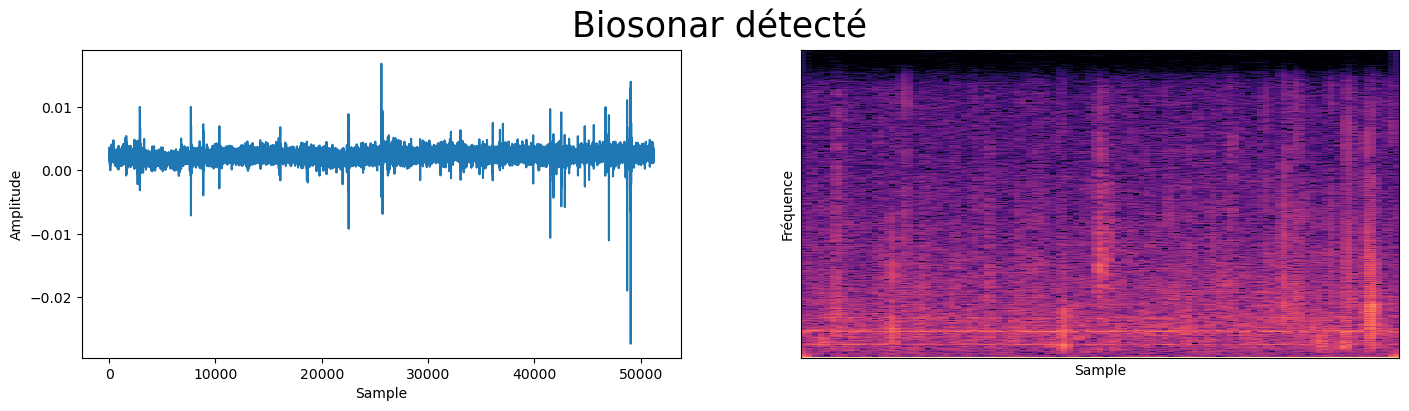

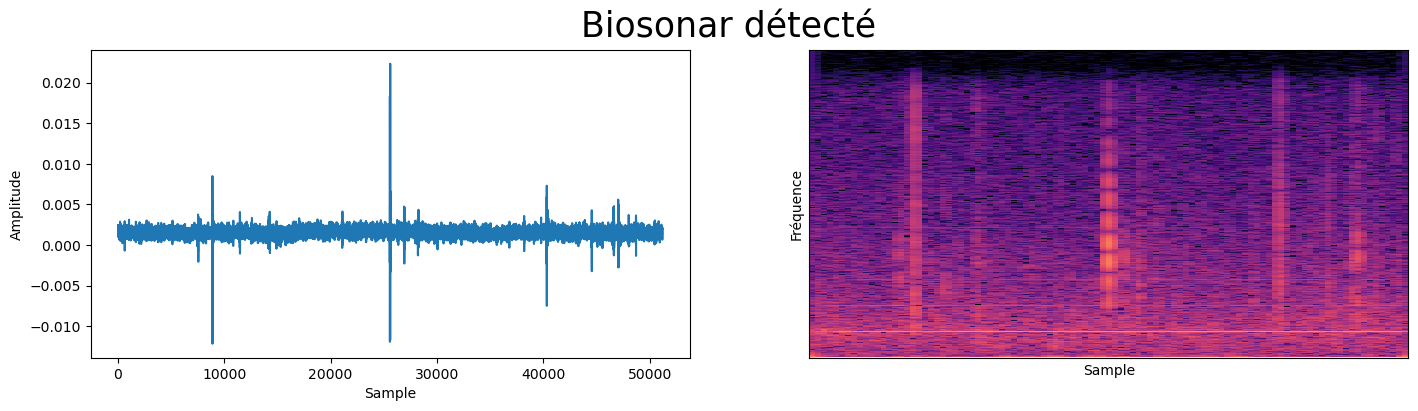

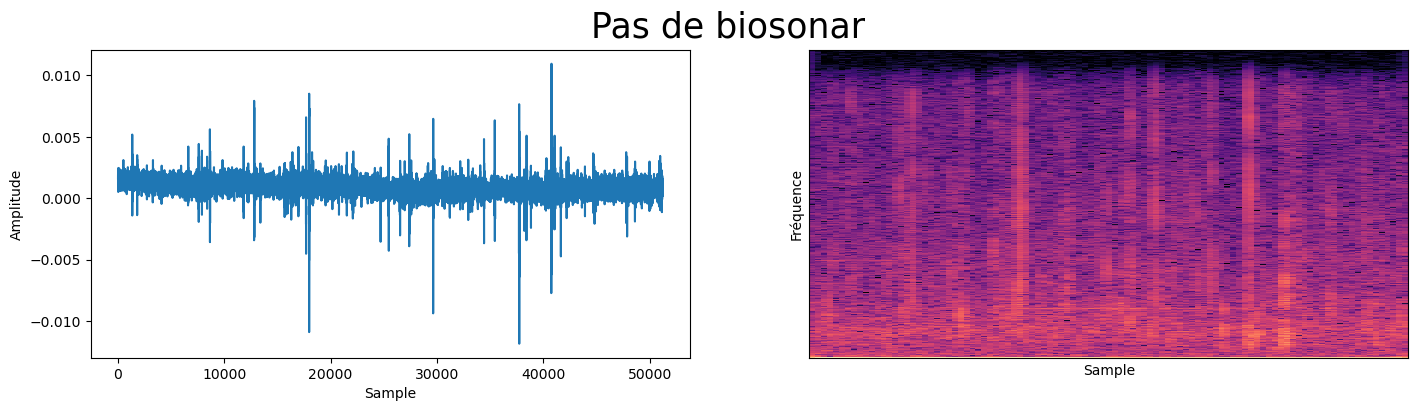

In [10]:
#import soundfile as sf
from random import sample
import librosa as lr
import librosa.display
import numpy as np

sample = sample(list_files,3)

for filename in sample:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 4))
    sig, sr = sf.read(r'.\data\X_train\\' + filename)
    
    tf_sig = lr.stft(sig, n_fft=2048)
    tf_sig = np.abs(tf_sig)
    
    ax1.plot(sig)
    ax1.set(xlabel='Sample', ylabel='Amplitude')

    lr.display.specshow(lr.amplitude_to_db(tf_sig, ref=np.max))
    ax2.set(xlabel='Sample', ylabel='Fréquence')
    
    if(Y[Y['nom'] == filename.split('.')[0]]['pos_label'].iloc[0] == 1):
        fig.suptitle('Biosonar détecté', fontsize =25)
    else : 
        fig.suptitle('Pas de biosonar', fontsize =25)
        
    
    plt.show()

In [12]:
sig.shape

(51200,)

### Corrélations dans le Data Frame

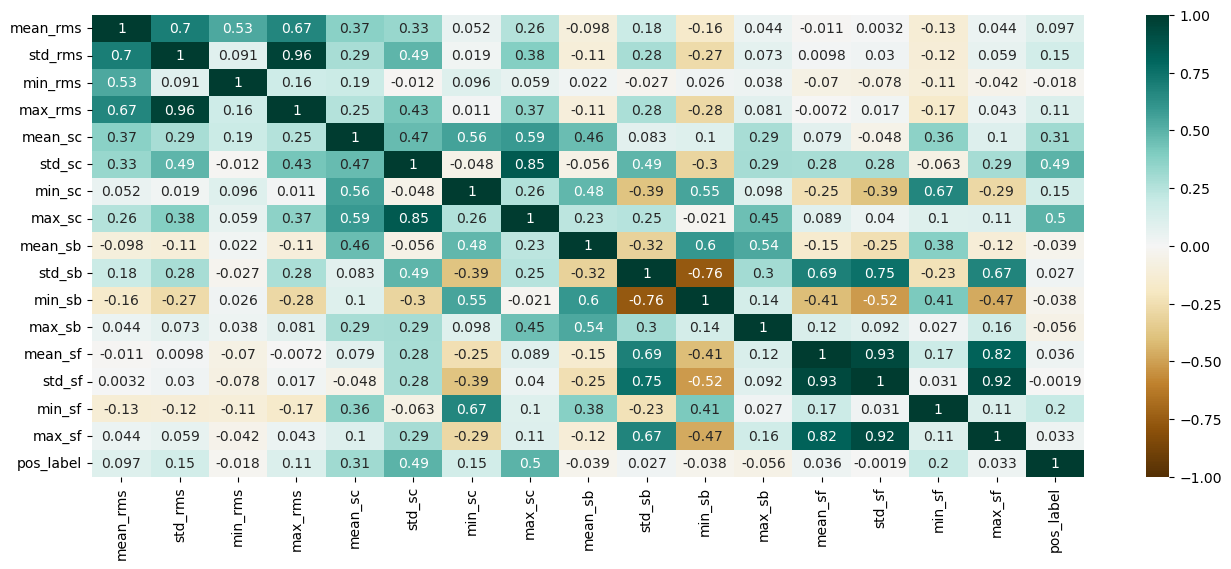

In [13]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

# Normalisation

In [14]:
# On utilise un MinMaxScaler
scaler = MinMaxScaler()

# Fit & transform
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.fit_transform(X_test)


print(X_train_normalized)

[[1.52217142e-02 2.24690449e-03 2.58302023e-02 ... 1.01945638e-02
  4.15688139e-01 3.03262937e-02]
 [3.09428326e-02 7.86705112e-03 3.63131984e-02 ... 7.06887310e-03
  3.26827060e-01 3.22145524e-02]
 [4.59680681e-02 8.25891486e-03 5.18482349e-02 ... 6.76312795e-03
  5.76742124e-02 3.13331087e-02]
 ...
 [1.17270648e-02 9.93623777e-04 2.43916995e-02 ... 7.29979179e-03
  3.68731014e-01 3.08392367e-02]
 [3.12572349e-02 1.53669236e-02 2.65156379e-02 ... 8.54091435e-03
  5.94906492e-01 3.35375616e-02]
 [6.34464863e-03 2.25652928e-04 2.08734864e-02 ... 9.42741946e-04
  1.04521898e-01 3.97095912e-03]]


In [15]:
#Après avoir testé, le standard scaler donne de meilleurs résultats
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

print(X_train_normalized)

[[-0.30041838 -0.28316471 -0.2788789  ... -0.07489646  0.10567715
  -0.30717092]
 [ 0.0875843  -0.05050406  0.26478717 ... -0.14198985 -0.46868556
  -0.27752385]
 [ 0.45841235 -0.03428184  1.07046067 ... -0.14855272 -2.20838261
  -0.29136317]
 ...
 [-0.38666754 -0.33504754 -0.35348211 ... -0.13703315 -0.19783505
  -0.29911733]
 [ 0.09534386  0.25997275 -0.24333104 ... -0.11039228  1.26407337
  -0.25675161]
 [-0.51950745 -0.3668397  -0.53594265 ... -0.27348812 -1.90557779
  -0.72096939]]


# Modele

In [16]:
# Le modele
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(16,1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# On compile le modèle
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
history = model.fit(X_train_normalized, y_train, epochs=10, batch_size=32, validation_data=(X_test_normalized, y_test))

Epoch 1/10
652/652 [==============================] - 1s 1ms/step - loss: 0.4323 - accuracy: 0.8273 - val_loss: 0.3680 - val_accuracy: 0.8567
Epoch 2/10
652/652 [==============================] - 1s 1ms/step - loss: 0.3544 - accuracy: 0.8614 - val_loss: 0.3407 - val_accuracy: 0.8649
Epoch 3/10
652/652 [==============================] - 1s 1ms/step - loss: 0.3332 - accuracy: 0.8676 - val_loss: 0.3198 - val_accuracy: 0.8787
Epoch 4/10
652/652 [==============================] - 1s 1ms/step - loss: 0.3198 - accuracy: 0.8745 - val_loss: 0.3042 - val_accuracy: 0.8835
Epoch 5/10
652/652 [==============================] - 1s 1ms/step - loss: 0.3077 - accuracy: 0.8802 - val_loss: 0.2906 - val_accuracy: 0.8899
Epoch 6/10
652/652 [==============================] - 1s 1ms/step - loss: 0.2995 - accuracy: 0.8823 - val_loss: 0.2872 - val_accuracy: 0.8921
Epoch 7/10
652/652 [==============================] - 1s 1ms/step - loss: 0.2919 - accuracy: 0.8859 - val_loss: 0.2749 - val_accuracy: 0.8968
Epoch 

In [17]:
# Evaluation de l'accuracy
test_loss, test_acc = model.evaluate(X_test_normalized, y_test)
print('Accuracy sur le test : ',test_acc)

73/73 [==============================] - 0s 764us/step - loss: 0.2566 - accuracy: 0.9072
Accuracy sur le test :  0.9072076082229614


73/73 [==============================] - 0s 623us/step


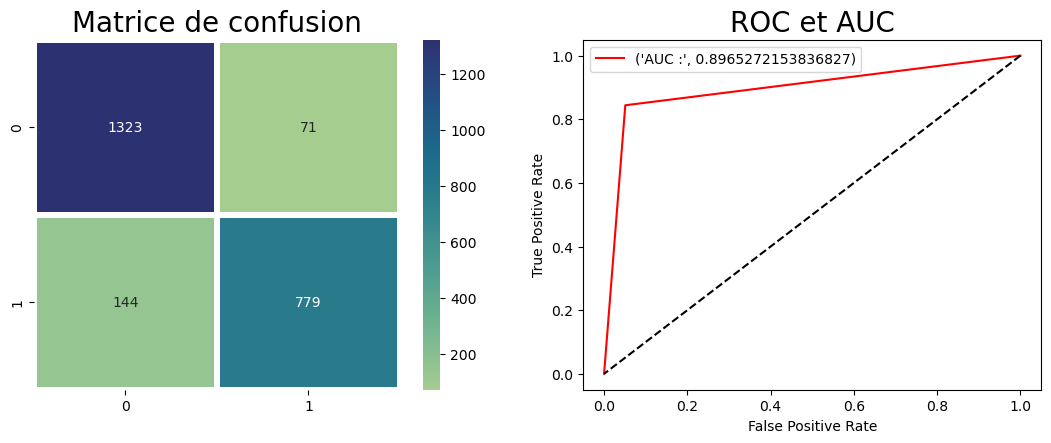

In [18]:
y_pred = model.predict(X_test_normalized)
threshold = 0.5
y_pred = (y_pred >= threshold).astype(int)

#Matrice de confusion
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap="crest",fmt = "d",linewidths=3)
plt.title("Matrice de confusion",fontsize=20)

#ROC et AUC
fpr,tpr,thresholds = roc_curve(y_test,y_pred)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("AUC :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC et AUC",fontsize=20);

# Data Augmentation 

Nous allons essayer d'augmenter les performances du modèle en élargissant le data set avec des transformations aléatoires

In [51]:
import librosa

def import_sons(nom):
    import soundfile as sf
    filename = nom 
    sig, sr = sf.read(r'.\data\X_train\\' + filename)
    
    #time stretching
    stretch_factor = np.random.uniform(0.8, 1.2)
    audio_stretched = librosa.effects.time_stretch(sig, rate=stretch_factor)

    #pitch shifting
    #pitch_shift_steps = np.random.randint(-3, 4)
    #audio_pitch_shifted = librosa.effects.pitch_shift(sig, sr=sr, n_steps=pitch_shift_steps)
    

    return([nom] + traite_son(sig, sr), [nom] + traite_son(audio_stretched, sr))#, [nom] + traite_son(audio_pitch_shifted, sr))

    
def traite_son(sig, sr):
    sos = signal.butter(6, [5000, 100000], 'bandpass', fs=sr, output='sos')
    sig = signal.sosfiltfilt(sos, sig)
    rms = feat.rms(y=sig) 
    sc = feat.spectral_centroid(y=sig, sr=sr)
    sb = feat.spectral_bandwidth(y=sig,sr=sr)
    sf = feat.spectral_flatness(y=sig)

    features = [np.mean(rms), np.std(rms), np.min(rms), np.max(rms),\
                np.mean(sc), np.std(sc), np.min(sc), np.max(sc),\
                np.mean(sb), np.std(sb), np.min(sb), np.max(sb),\
                np.mean(sf), np.std(sf), np.min(sf), np.max(sf)]
    return(features)



df2 = pd.DataFrame(columns = ['nom','mean_rms', 'std_rms', 'min_rms', 'max_rms',
                'mean_sc', 'std_sc', 'min_sc', 'max_sc',
                'mean_sb', 'std_sb', 'min_sb', 'max_sb',
                'mean_sf', 'std_sf', 'min_sf', 'max_sf'])

for i in list_files:
    #new_row1,new_row2,new_row3 = import_sons(i)
    new_row1,new_row2 = import_sons(i)
    df2.loc[len(df2)] = new_row1
    df2.loc[len(df2)] = new_row2
    #df2.loc[len(df2)] = new_row3
    
df2.head()

,nom,mean_rms,std_rms,min_rms,max_rms,mean_sc,std_sc,min_sc,max_sc,mean_sb,std_sb,min_sb,max_sb,mean_sf,std_sf,min_sf,max_sf
0,00000-JAM.wav,0.000306,0.000067,0.000188,0.000488,33091.410037,1476.154209,29273.938993,36801.024729,24774.591555,795.562058,21782.369512,26305.819243,0.019416,0.006762,0.009422,0.073818
1,00000-JAM.wav,0.000222,0.000042,0.000165,0.000318,33203.836664,1357.480415,29911.169319,36527.003757,24787.564401,739.389769,22236.461514,25820.337422,0.020101,0.003394,0.011251,0.038927
2,00001-JAM.wav,0.000336,0.000125,0.000168,0.000886,34378.653061,2948.158021,28935.108670,45693.603144,25242.833502,1002.853259,23035.653604,27829.674762,0.021222,0.007939,0.010541,0.072316
3,00001-JAM.wav,0.000233,0.000077,0.000137,0.000605,34602.274010,2795.896638,30037.647790,44819.879980,25296.469773,964.263546,23334.223681,28080.681525,0.021007,0.004669,0.011742,0.044250
4,00002-JAM.wav,0.000350,0.000163,0.000161,0.000915,34593.831292,3156.256999,30212.095058,45775.249244,25244.598160,853.897949,23186.677123,27835.712913,0.021065,0.006066,0.011405,0.062272


In [69]:
df2.to_pickle(r'.\data\dataframe_augmented.pkl')

In [70]:
len(df2)

46336

In [19]:
#On join les DataFrames
X = pd.read_pickle(r'.\data\dataframe_augmented.pkl')
Y = pd.read_csv('.\data\Y_train_ofTdMHi.csv')
Y['nom'] = Y['id']
Y =Y.drop('id', axis = 1)


In [20]:
df = X.join(Y.set_index('nom'), on='nom', validate='m:1')
df

,nom,mean_rms,std_rms,min_rms,max_rms,mean_sc,std_sc,min_sc,max_sc,mean_sb,std_sb,min_sb,max_sb,mean_sf,std_sf,min_sf,max_sf,pos_label
0,00000-JAM.wav,0.000306,0.000067,0.000188,0.000488,33091.410037,1476.154209,29273.938993,36801.024729,24774.591555,795.562058,21782.369512,26305.819243,0.019416,0.006762,0.009422,0.073818,0.0
1,00000-JAM.wav,0.000222,0.000042,0.000165,0.000318,33203.836664,1357.480415,29911.169319,36527.003757,24787.564401,739.389769,22236.461514,25820.337422,0.020101,0.003394,0.011251,0.038927,0.0
2,00001-JAM.wav,0.000336,0.000125,0.000168,0.000886,34378.653061,2948.158021,28935.108670,45693.603144,25242.833502,1002.853259,23035.653604,27829.674762,0.021222,0.007939,0.010541,0.072316,1.0
3,00001-JAM.wav,0.000233,0.000077,0.000137,0.000605,34602.274010,2795.896638,30037.647790,44819.879980,25296.469773,964.263546,23334.223681,28080.681525,0.021007,0.004669,0.011742,0.044250,1.0
4,00002-JAM.wav,0.000350,0.000163,0.000161,0.000915,34593.831292,3156.256999,30212.095058,45775.249244,25244.598160,853.897949,23186.677123,27835.712913,0.021065,0.006066,0.011405,0.062272,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46331,23165-StMARTIN.wav,0.005433,0.004470,0.000297,0.012849,25889.868364,7358.253604,16507.795045,44487.429627,23005.499321,2470.720270,18418.473139,27684.226041,0.007782,0.010861,0.000385,0.067295,0.0
46332,23166-StMARTIN.wav,0.014010,0.003323,0.000532,0.026707,20982.874469,2426.708451,16905.249559,28325.176302,22216.843367,1165.290580,20056.578526,25350.175433,0.001703,0.001460,0.000489,0.011945,0.0
46333,23166-StMARTIN.wav,0.014131,0.003051,0.002178,0.026706,20960.918738,2419.581110,16905.608430,28055.793855,22206.009247,1163.256243,20056.543789,25350.171405,0.001605,0.001029,0.000489,0.008557,0.0
46334,23167-StMARTIN.wav,0.012639,0.006017,0.000156,0.028727,21473.234387,3707.178854,16905.249559,33589.842966,21831.087556,1513.646712,16432.623004,26179.365157,0.003057,0.004236,0.000489,0.021524,0.0


In [21]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['pos_label','nom'], axis = 1), df['pos_label'], test_size=0.1, random_state=42)

In [31]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [56]:
# Le modèle
model = Sequential([
    Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(16,1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=4, activation='relu'),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# On compile le modèle
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
history = model.fit(X_train_normalized, y_train, epochs=20, batch_size=16, validation_data=(X_test_normalized, y_test))

Epoch 1/20
2607/2607 [==============================] - 4s 1ms/step - loss: 0.3107 - accuracy: 0.8787 - val_loss: 0.2689 - val_accuracy: 0.8960
Epoch 2/20
2607/2607 [==============================] - 3s 1ms/step - loss: 0.2618 - accuracy: 0.8972 - val_loss: 0.2452 - val_accuracy: 0.9035
Epoch 3/20
2607/2607 [==============================] - 3s 1ms/step - loss: 0.2479 - accuracy: 0.9030 - val_loss: 0.2556 - val_accuracy: 0.8953
Epoch 4/20
2607/2607 [==============================] - 3s 1ms/step - loss: 0.2402 - accuracy: 0.9080 - val_loss: 0.2364 - val_accuracy: 0.9063
Epoch 5/20
2607/2607 [==============================] - 3s 1ms/step - loss: 0.2340 - accuracy: 0.9111 - val_loss: 0.2307 - val_accuracy: 0.9072
Epoch 6/20
2607/2607 [==============================] - 3s 1ms/step - loss: 0.2293 - accuracy: 0.9127 - val_loss: 0.2373 - val_accuracy: 0.9068
Epoch 7/20
2607/2607 [==============================] - 3s 1ms/step - loss: 0.2236 - accuracy: 0.9143 - val_loss: 0.2275 - val_accuracy:

145/145 [==============================] - 0s 689us/step


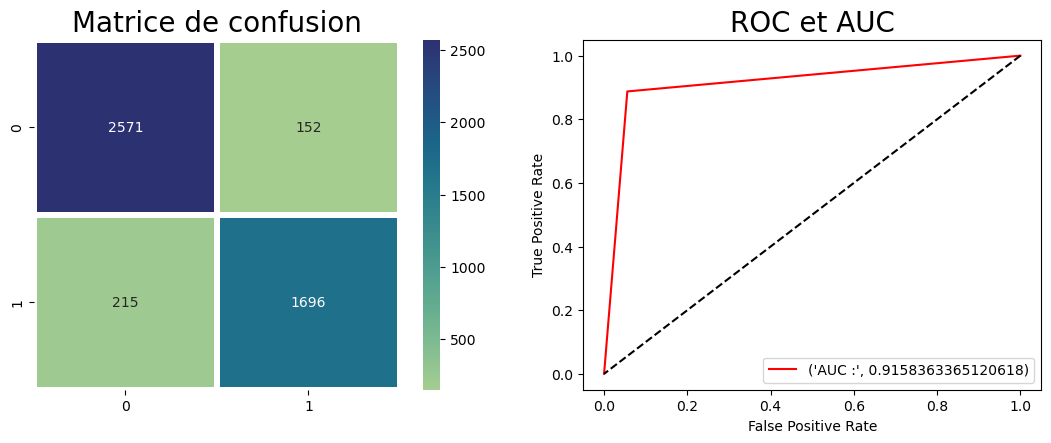

In [57]:
y_pred = model.predict(X_test_normalized)
threshold = 0.5
y_pred = (y_pred >= threshold).astype(int)

#Matrice de confusion
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap="crest",fmt = "d",linewidths=3)
plt.title("Matrice de confusion",fontsize=20)

#ROC et AUC
fpr,tpr,thresholds = roc_curve(y_test,y_pred)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("AUC :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC et AUC",fontsize=20);

# Comparaison avec les modèles de ML "classiques"

Nous allons ici implémenter des algorithmes de machine learning plus classiques afin de comparer les résultats

### Régression logistique

Accuracy: 0.8228312473025464


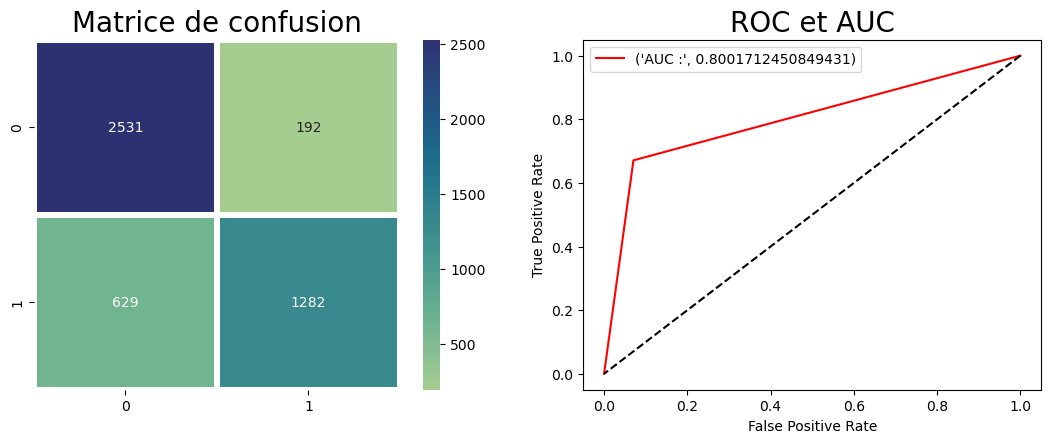

In [27]:
from sklearn.linear_model import LogisticRegression
# On utilise un MinMaxScaler
scaler = MinMaxScaler()

# Fit & transform
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.fit_transform(X_test)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_normalized, y_train)


y_pred = lr.predict(X_test_normalized)

#Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


#Matrice de confusion
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap="crest",fmt = "d",linewidths=3)
plt.title("Matrice de confusion",fontsize=20)

#ROC et AUC
fpr,tpr,thresholds = roc_curve(y_test,y_pred)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("AUC :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC et AUC",fontsize=20);

### Random Forest

Accuracy: 0.8584376348726802


Text(0.5, 1.0, 'ROC et AUC')

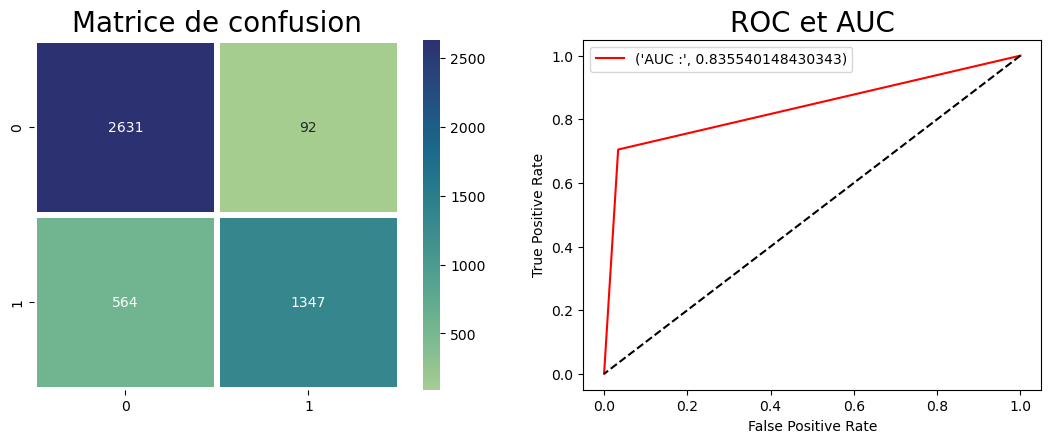

In [28]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=16, random_state=42)

rfc.fit(X_train_normalized, y_train)

y_pred = rfc.predict(X_test_normalized)

#Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


#Matrice de confusion
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap="crest",fmt = "d",linewidths=3)
plt.title("Matrice de confusion",fontsize=20)

#ROC et AUC
fpr,tpr,thresholds = roc_curve(y_test,y_pred)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("AUC :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC et AUC",fontsize=20)